In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from functools import partial
from matplotlib import colormaps as cm

In [2]:
sin = lambda x: jnp.sin(x)
cos = lambda x: jnp.cos(x)
pi = jnp.pi

In [3]:
L = 2*pi
NX = NY = 128
X_START = 0.
X_END = L
Y_START = 0.
Y_END = L
T_START = 0.
T_END = 20.
dt = 1e-2
NT = int((T_END - T_START)/dt)
#TOL = 1e-5
#TOL_poisson = 1e-5
Re = 2e3

## Space-Time Domain

In [4]:
x = jnp.linspace(X_START, X_END, NX + 1)
y = jnp.linspace(Y_START, Y_END, NY + 1)
X, Y = jnp.meshgrid(x, y)

In [5]:
t = jnp.linspace(T_START, T_END, NT + 1)

In [6]:
dx = x[1] - x[0]
dy = y[1] - y[0]

In [7]:
hx = 2. * pi / (NX * dx)
hy = 2. * pi / (NY * dy)

## Initial Conditions

In [8]:
@jax.jit
def omega_init_func(i, j, x=x, y=y, pi=pi, exp=jnp.exp, xc1=0.75*pi, yc1=pi, xc2=1.25*pi, yc2=pi):
    return exp(-pi*((x[i] - xc1)**2 + (y[j] - yc1)**2)) +\
           exp(-pi*((x[i] - xc2)**2 + (y[j] - yc2)**2))
           
oif_vmapped = jax.vmap(jax.vmap(omega_init_func, in_axes=(None, 0)), in_axes=(0, None))

In [9]:
psi_init = jnp.empty((NX+1, NY+1))
omega_init = jnp.empty((NX+1, NY+1))
omega_init = omega_init.at[1:, 1:].set(oif_vmapped(jnp.arange(1, NX+1), jnp.arange(1, NY+1)))
omega_init = omega_init.at[0, :].set(omega_init[-2, :])
omega_init = omega_init.at[:, 0].set(omega_init[:, -2])
omega_init = omega_init.at[-1, :].set(omega_init[1, :])
omega_init = omega_init.at[:, -1].set(omega_init[:, 1])

## Specifics of Spectral Poisson Solver

In [10]:
m_arr = jnp.empty(NX)
m_arr = m_arr.at[jnp.arange(0, int(NX/2))].set(hx * jnp.arange(0, int(NX/2))) 
m_arr = m_arr.at[jnp.arange(int(NX/2), NX)].set(hx * jnp.arange(-int(NX/2), 0))

In [11]:
n_arr = jnp.empty(NY)
n_arr = n_arr.at[jnp.arange(0, int(NY/2))].set(hy * jnp.arange(0, int(NY/2))) 
n_arr = n_arr.at[jnp.arange(int(NY/2), NY)].set(hy * jnp.arange(-int(NY/2), 0))

In [12]:
psi_tilda = lambda m, n: -(m**2 + n**2)
psi_den = jax.vmap(jax.vmap(psi_tilda, in_axes=(None, 0)), in_axes=(0, None))(m_arr, n_arr)
psi_den = psi_den.at[0,0].set(jnp.finfo(float).eps)

## Spectral Poisson Solver

In [13]:
@jax.jit
def spectral_preprocess(omega):
    return -omega[1:, 1:].astype(complex)

@jax.jit
def spectral_poisson_solver(omega_preproc, den=psi_den):
    omega_tilda = jnp.fft.fftn(omega_preproc)
    omega_tilda = omega_tilda.at[0, 0].set(complex(0,0))
    psi_tilda = omega_tilda/den
    return jnp.real(jnp.fft.ifftn(psi_tilda))

@jax.jit
def periodic_bc(psi, psi_spectral):
    output = jnp.zeros_like(psi)
    output = output.at[1:, 1:].set(psi_spectral)
    output = output.at[-1, :-1].set(psi_spectral[1, :])
    output = output.at[:-1, -1].set(psi_spectral[:, 1])  
    output = output.at[0, :-1].set(psi_spectral[-2, :])
    return  output.at[:-1, 0].set(psi_spectral[:, -2])


In [14]:
psi_init = psi_init.at[:,:].set(periodic_bc(psi_init, spectral_poisson_solver(spectral_preprocess(omega_init))))

In [15]:
omega_psi_init = jnp.stack((omega_init, psi_init))

## NS Solver

In [16]:
@jax.jit
def bound_cond(omega):
    omega = omega.at[0, :].set(omega[-2, :])
    omega = omega.at[:, 0].set(omega[:, -2])
    omega = omega.at[-1, :].set(omega[1, :])
    return omega.at[:, -1].set(omega[:, 1])

In [17]:
# rhs of the naiver stokes equation (Arakawa numerical scheme for Jacobian)
@jax.jit
def ns_rhs(i, j, omega, psi, dx=dx, dy=dy, Re=Re):
    
    aa = 1./(Re*dx**2)
    bb = 1./(Re*dy**2)
    gg = 1./(4.*dx*dy)
    hh = 1./3.
    
    j1 = gg*((omega[i+1,j] - omega[i-1,j])*(psi[i,j+1] - psi[i,j-1]) -\
             (omega[i,j+1] - omega[i,j-1])*(psi[i+1,j] - psi[i-1,j]))
    
    j2 = gg*((omega[i+1,j]*(psi[i+1, j+1] - psi[i+1, j-1])) -\
             (omega[i-1,j]*(psi[i-1, j+1] - psi[i-1, j-1])) -\
             (omega[i,j+1]*(psi[i+1, j+1] - psi[i-1, j+1])) +\
             (omega[i,j-1]*(psi[i+1, j-1] - psi[i-1, j-1])))
    
    j3 = gg*((omega[i+1,j+1]*(psi[i, j+1] - psi[i+1, j])) -\
             (omega[i-1,j-1]*(psi[i-1, j] - psi[i, j-1])) -\
             (omega[i-1,j+1]*(psi[i, j+1] - psi[i-1, j])) +\
             (omega[i+1,j-1]*(psi[i+1, j] - psi[i, j-1])))
    
    jac = (j1+j2+j3)*hh
    
    return -jac + aa*(omega[i+1,j] - 2.*omega[i,j] + omega[i-1, j]) +\
                  bb*(omega[i,j+1] - 2.*omega[i,j] + omega[i, j-1])

@jax.jit                 
def rhs_processed(omega, psi, index_x=jnp.arange(1, NX), index_y=jnp.arange(1, NY)):
       ns_rhs_spec = lambda i, j: ns_rhs(i, j, omega=omega, psi=psi)
       ns_rhs_spec_vmapped = jax.vmap(jax.vmap(ns_rhs_spec, in_axes=(None, 0)), in_axes=(0, None))
       
       rhs = jnp.zeros_like(omega)
       return rhs.at[1:-1, 1:-1].set(ns_rhs_spec_vmapped(index_x, index_y))

In [18]:
# Time integration: RK-3 and Space-discretization: 2nd order finite difference
def solver_one_step(iter, omega_psi, dt=dt):
    omega, psi = omega_psi
    omega_temp = jnp.empty_like(omega)
    
    rhs = rhs_processed(omega, psi)
    omega_temp = omega_temp.at[1:-1, 1:-1].set(omega[1:-1, 1:-1] + dt*rhs[1:-1, 1:-1]) # first step RK
    omega_temp = omega_temp.at[:, :].set(bound_cond(omega_temp)) # update boundary
    omega_temp_comp = spectral_preprocess(omega_temp)
    psi = psi.at[:, :].set(periodic_bc(psi, spectral_poisson_solver(omega_temp_comp))) # solve for psi
    
    rhs = rhs.at[:, :].set(rhs_processed(omega_temp, psi))
    omega_temp = omega_temp.at[1:-1, 1:-1].set(0.75*omega[1:-1, 1:-1] +\
                                               0.25*(omega_temp[1:-1, 1:-1]+ dt*rhs[1:-1, 1:-1])) # second step RK
    omega_temp = omega_temp.at[:, :].set(bound_cond(omega_temp)) # update boundary
    omega_temp_comp = omega_temp_comp.at[:,:].set(spectral_preprocess(omega_temp))
    psi = psi.at[:, :].set(periodic_bc(psi, spectral_poisson_solver(omega_temp_comp))) # solve for psi
    
    rhs = rhs.at[:, :].set(rhs_processed(omega_temp, psi))
    omega_temp = omega_temp.at[1:-1, 1:-1].set((1/3)*omega[1:-1, 1:-1] +\
                                               (2/3)*(omega_temp[1:-1, 1:-1]+ dt*rhs[1:-1, 1:-1])) # third step RK
    omega_temp = omega_temp.at[:, :].set(bound_cond(omega_temp)) # update boundary
    omega_temp_comp = omega_temp_comp.at[:,:].set(spectral_preprocess(omega_temp))
    psi = psi.at[:, :].set(periodic_bc(psi, spectral_poisson_solver(omega_temp_comp))) # solve for psi
    
    return jnp.stack((omega_temp, psi))  
    
num_solver = lambda omega_psi, NT: jax.lax.fori_loop(0, NT, solver_one_step, omega_psi)

In [19]:
final_omega,final_psi = num_solver(omega_psi_init, NT)

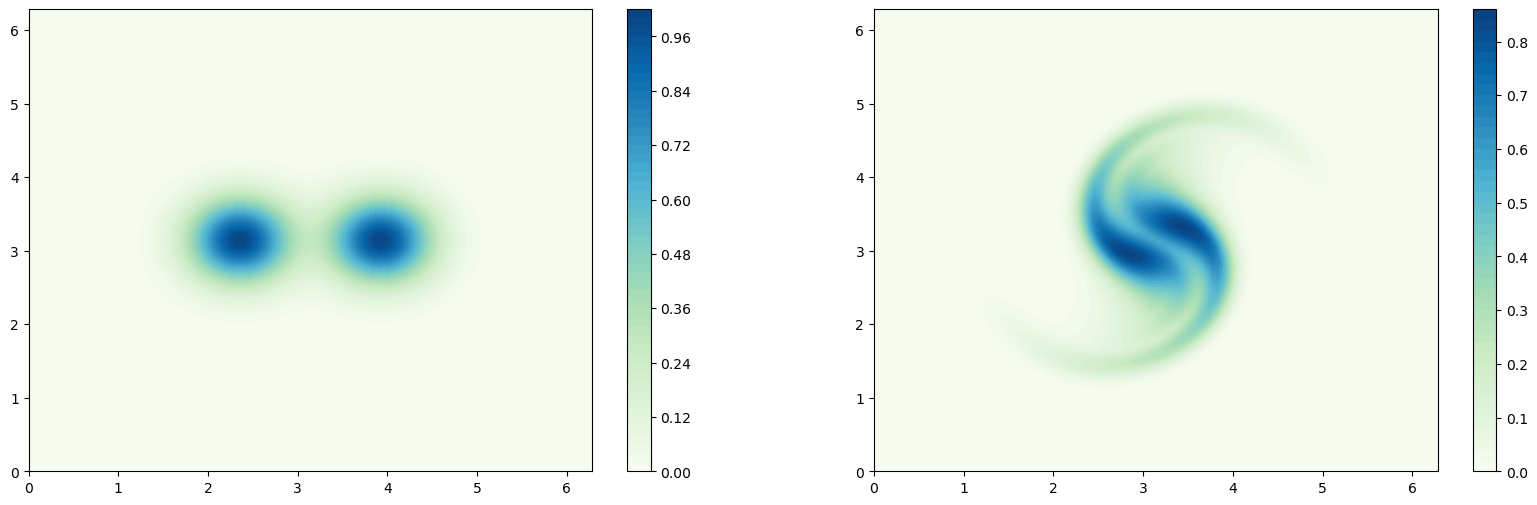

In [20]:
fig, axs = plt.subplots(1,2, figsize=(20, 6))
vorticity = axs[1].contourf(Y, X, final_omega, 50, cmap=cm.get_cmap('GnBu'))
vorticity_init = axs[0].contourf(Y, X, omega_init, 50, cmap=cm.get_cmap('GnBu'))

fig.colorbar(vorticity)
fig.colorbar(vorticity_init)
plt.show()